In [1]:
## PRIMERIA APROXIMACION AL LENTE DE QUADMODEL DEL RUNG0
# Llamamos todas las librerias que se usan en Lenstronomy, tomandolas del Rung005

## LLAMANDO LIBRERIAS DE LENSTRONOMY
import numpy as np                                  # Libreria numerica, definimos numeros
import time                                         # Libreria de simulacion.
import corner
import matplotlib.pyplot as plt
import matplotlib
import os
import copy
import astropy.io.fits as pyfits
import astropy
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Plots.output_plots as lens_plot
import matplotlib.pyplot as plt
%matplotlib inline

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from lenstronomy.Util import constants

import lenstronomy.Util.param_util as param_util

from lenstronomy.ImSim.image_model import ImageModel

from lenstronomy.PointSource.point_source import PointSource

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions

from lenstronomy.LightModel.light_model import LightModel

from lenstronomy.Sampling.parameters import Param

from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

from lenstronomy.Cosmo.lens_cosmo import LensCosmo

from astropy.cosmology import FlatLambdaCDM

from astropy.io import fits

from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

In [2]:
## Definimos condiciones COSMOLOGICAS Y OBSERVACIONALES.

# Condiciones observacionales, estas librerias nos determinan condiciones para simulacion de imagenes
background_rms = .05  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 99  # cutout pixel size
#delta pix parametro a utilizar por el PSF creemos que se relaciona con el brillo
deltaPix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.8  # full width half max of PSF

# Condiciones cosmologicas, distancias de la lente y del medio
z_lens = 0.858
z_source = 2.175

# Tipo de cosmologia a utilizar, esto es importante para la reconstruccion de la lente en masa

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)
lensCosmo = LensCosmo(cosmo=cosmo, z_lens=z_lens, z_source=z_source)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log10


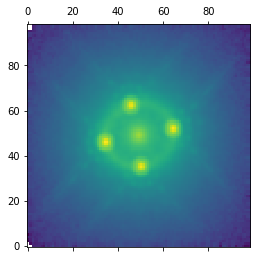

In [3]:
## ENTRADA DE DATOS, introducimos datos de la lente, psf y map noise, definiendolo como matriz.
# recuerde debemos estar en la libreria donde se encuentran las imagenes.

# Definimos entradas de las imagenes. inicialmente solo usaremos lens-image.fits
fits_image_filename = fits.util.get_testdata_filepath('lens-image.fits')
fits_noise_filename = fits.util.get_testdata_filepath('noise_map.fits')
fits_psf_filename = fits.util.get_testdata_filepath('psf.fits')

# Abrimos imagenes las definimos como matrices
hdul = fits.open('lens-image.fits')
hdulnoise = fits.open('noise_map.fits')
hdulpsf = fits.open('psf.fits')

image_data = hdul[0].data
noise_data = hdulnoise[0].data
psf_data = hdulpsf[0].data

# librerias data de imagen y ruido
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)

# librerias data de psf, son diferentes para psf como para imagenes.
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 8}
psf_class = PSF(**kwargs_psf)

# subimos las imagenes mediante la rutina update date, de imaging data.
data_class.update_data(image_data)
kwargs_data['image_data'] = image_data
#""
#data_class.update_data(noise_data)
#kwargs_data['noise_map'] = noise_data

#data_class.update_data(psf_data)
#kwargs_psf['psf'] = psf_data

# para corroborar que si subimos las imagenes, las imprimimos
plt.matshow(np.log10(image_data), origin='lower')
plt.show()
#""
#plt.matshow(np.log10(noise_data), origin='lower')
#plt.show()

#plt.matshow(np.log10(psf_data), origin='lower')
#plt.show()"""

In [4]:
## DFINICION DE VALORES INCICIALES
from numpy import array

# Esta sección es una unificación entre lo valores que se obtuvieron por EXCEL y los valores iniciales
# de la simulación, inicialmente restringimos valores a los aproximados de EXCEL.

# Con la ayuda de IRAF deterinamos la ubicacion en pixeles, sabiendo que cada pixel son 0.08" para drizzzle images
# el centro esta ubicado en pixeles x = 49.919 y = 50.002
x_A = 0.08480
x_B = -1.16496
x_C = 1.21336
x_D = -0.27544

y_A = -1.09936
y_B = -0.24800
y_C = 0.22269
y_D = 1.05784

# Definimos valor de Anillo de Einstein Inicial
theta_E = 1.155297871

# Definimos ubicacion de las imagenes en la lente.
x_list = [x_A, x_B, x_C, x_D]
y_list = [y_A, y_B, y_C, y_D]

x_image = array(x_list)
y_image = array(y_list)

print(x_image)
type(x_image)

[ 0.0848  -1.16496  1.21336 -0.27544]


numpy.ndarray

In [5]:
# TRANSICIÓN ENTRE LA IMAGEN REAL Y LOS VALORES A SIMULAR.
# Definimos condiciones de simulacion de la lente.

# Definimos el tipo de modelo de lente que necesitamos, lens_model_list
# para esta primera simulacion escogemos SPEMD Y SHEAR, esto debido a que ya conocemos los resultados.
lens_model_list = ['SPEMD','SHEAR_GAMMA_PSI']
# definimos tambien la clase
lens_model_class = LensModel(lens_model_list=lens_model_list)

# Definimos modelo de luz de la fuente SOURCE AGN, tenemos la opcion de puntual, sersic y sersic ellipse
source_model_list = ['SERSIC_ELLIPSE']

# Definimos modelo de luz de la lente, LENS, es una galaxia no activa. Sabemos que es Elliptica debido a las
# respuestas del RUNG-0
lens_light_model_list = ['SERSIC_ELLIPSE']

# Usamos la libreria point source Desconocemos su utilidad, podemos inicialmente obviarlo
# Debemos solucionar la ecacion de lente para encontrar las ubicaciones de las imagenes en el 
# plano de la lente, sin embargo las ubicaciones ya la determinamos
point_source_list = ['LENSED_POSITION']

kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list,
                'point_source_model_list': point_source_list,
                'additional_images_list': [False],
                'fixed_magnification_list': [False],
                             }
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

num_source_model = len(source_model_list)

kwargs_constraints = {'joint_source_with_point_source': [[0, 0]],
                              'num_point_source_list': [4],
                              'solver_type': 'PROFILE',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                              }

kwargs_likelihood = {'check_bounds': True,
                             'force_no_add_image': False,
                             'source_marg': False,
                             'position_uncertainty': 0.004,
                             'check_solver': True,
                             'solver_tolerance': 0.001
                             }

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

print(x_image)
print(y_image)

[ 0.0848  -1.16496  1.21336 -0.27544]
[-1.09936 -0.248    0.22269  1.05784]


In [6]:
################# SIMULACION HARDCORE #####################
# En erste punto habiendo definido mis condiciones iniciales corremos simulacion
# initial guess of non-linear parameters, we chose different starting parameters than the truth #


# initial guess of non-linear parameters, we chose different starting parameters than the truth #
kwargs_lens_init = [{'theta_E': 1.2, 'e1': 0, 'e2': 0, 'gamma': 2., 'center_x': 0., 'center_y': 0},
    {'gamma_ext': 0.01, 'psi_ext': 0.}]
kwargs_source_init = [{'R_sersic': 0.03, 'n_sersic': 1., 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_lens_light_init = [{'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_ps_init = [{'ra_image': x_image+0.01, 'dec_image': y_image-0.01}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.3, 'e1': 0.2, 'e2': 0.2, 'gamma': .2, 'center_x': 0.1, 'center_y': 0.1},
    {'gamma_ext': 0.1, 'psi_ext': np.pi}]
kwargs_source_sigma = [{'R_sersic': 0.1, 'n_sersic': .5, 'center_x': .1, 'center_y': 0.1, 'e1': 0.2, 'e2': 0.2}]
kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': 0.1}]
kwargs_ps_sigma = [{'ra_image': [0.02] * 4, 'dec_image': [0.02] * 4}]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10., 'center_y': -10},
    {'gamma_ext': 0., 'psi_ext': -np.pi}]
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(x_image), 'dec_image': -10 * np.ones_like(y_image)}]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10., 'center_y': 10},
    {'gamma_ext': 0.3, 'psi_ext': np.pi}]
kwargs_upper_source = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(x_image), 'dec_image': 10 * np.ones_like(y_image)}]

lens_params = [kwargs_lens_init, kwargs_lens_sigma, [{}, {'ra_0': 0, 'dec_0': 0}], kwargs_lower_lens, kwargs_upper_lens]
source_params = [kwargs_source_init, kwargs_source_sigma, [{}], kwargs_lower_source, kwargs_upper_source]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, [{}], kwargs_lower_lens_light, kwargs_upper_lens_light]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, [{}], kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params}

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 400}],
                       ['MCMC', {'n_burn': 100, 'n_run': 10, 'walkerRatio': 2, 'sigma_scale': .01}]
        ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
max iteration reached! stoping
-53.65487527956669 reduced X^2 of best position
-262265.03036652197 logL
9776 effective number of data points
[{'theta_E': 1.0966387189697429, 'gamma': 1.724563292047474, 'e1': -0.02386338983366616, 'e2': 0.0009860835523401133, 'center_x': 0.01489834504481638, 'center_y': 0.01275191695217606}, {'gamma_ext': 0.027537229537558734, 'psi_ext': -2.567169123443916, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.002187501894615774, 'n_sersic': 0.5986317887212956, 'e1': 0.40099106020491676, 'e2': -0.20583830446020457, 'center_x': 0.02980583511342855, 'center_y': 0.013324561915343328}] source result
[{'amp': 1, 'R_sersic': 0.019539295219056098, 'n_sersic': 0.8729796301446499, 'center_x': 0.07715968138795863, 'center_y': -0.002094238231393978}] lens light result
[{'ra_image': array([ 0.08241135, -1.12943438,  1.20777205, -0.27447638]), 'dec_image': array([-1.

C:\Users\usuario\AppData\Roaming\Python\Python37\site-packages\emcee\ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
C:\Users\usuario\AppData\Roaming\Python\Python37\site-packages\emcee\ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


InMemoryStorageUtil does not support storeRandomState
19.769978046417236 time taken for MCMC sampling
[WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\usuario\\AppData\\Local\\Temp\\tmpddq5nm_6Hammer\\logs.log' shutil.rmtree did not work


reduced chi^2 =  11.309009820004162
(19, ['gamma_lens0', 'gamma_ext_lens1', 'psi_ext_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image'])


C:\ProgramData\Anaconda3\lib\site-packages\lenstronomy-0.9.1-py3.7.egg\lenstronomy\Plots\output_plots.py:499: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)
C:\ProgramData\Anaconda3\lib\site-packages\lenstronomy-0.9.1-py3.7.egg\lenstronomy\Plots\output_plots.py:1103: RuntimeWarning: invalid value encountered in true_divide
  dist_normed = (dist_averaged - np.max(dist_averaged)) / (np.max(dist_averaged) - np.min(dist_averaged))
C:\ProgramData\Anaconda3\lib\site-packages\lenstronomy-0.9.1-py3.7.egg\lenstronomy\Plots\output_plots.py:546: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
C:\ProgramData\Anaconda3\lib\site-packages\lenstronomy-0.9.1-py3.7.egg\lenstronomy\Plots\output_plots.py:581: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
C:\ProgramData\Anaconda3\lib\site-packages\lenstronomy-0.9.1-py3.7.egg\lenst

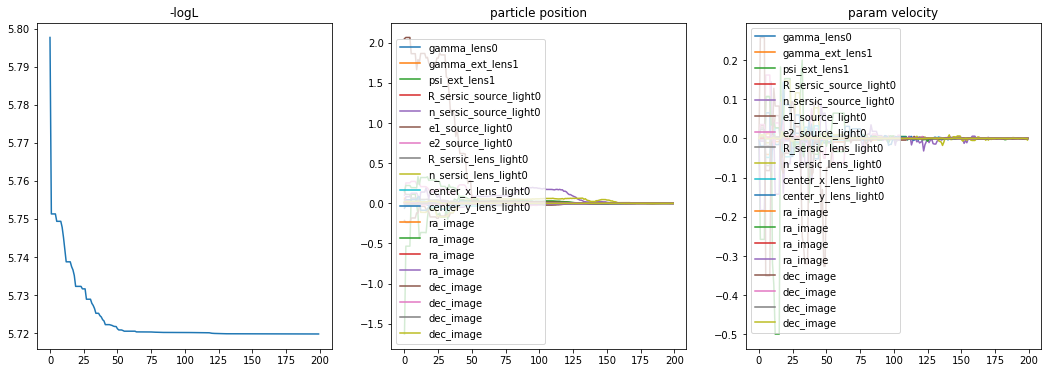

<Figure size 432x288 with 0 Axes>

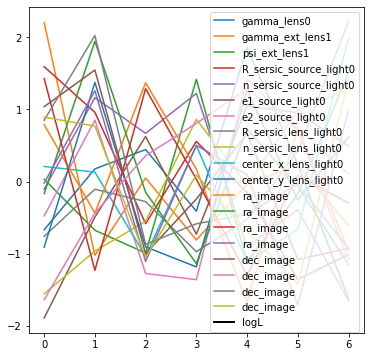

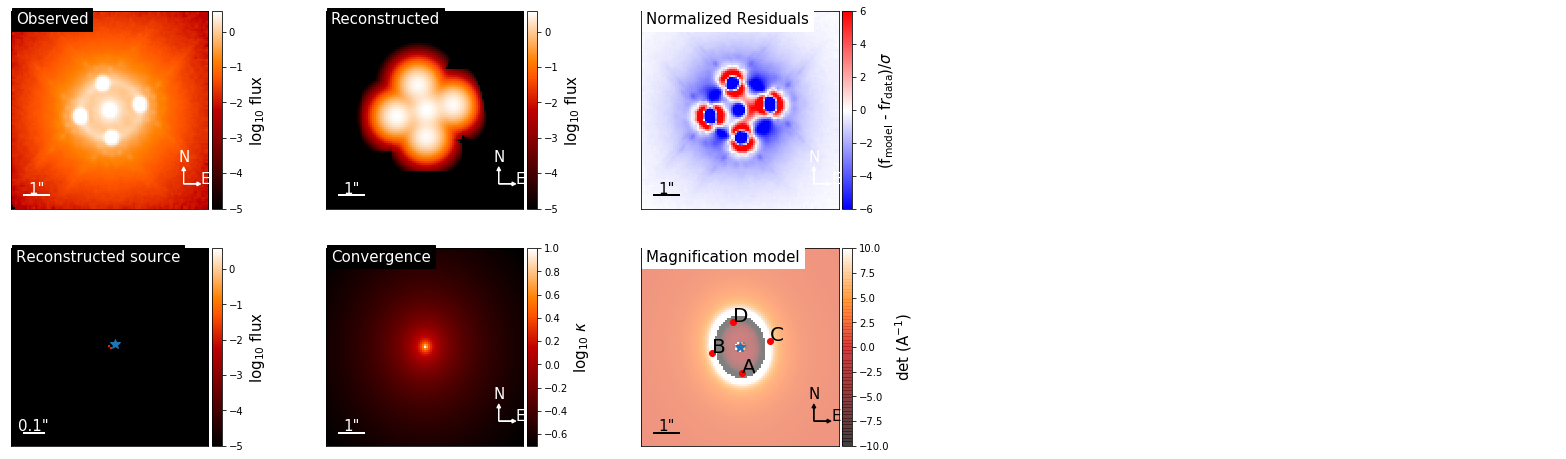

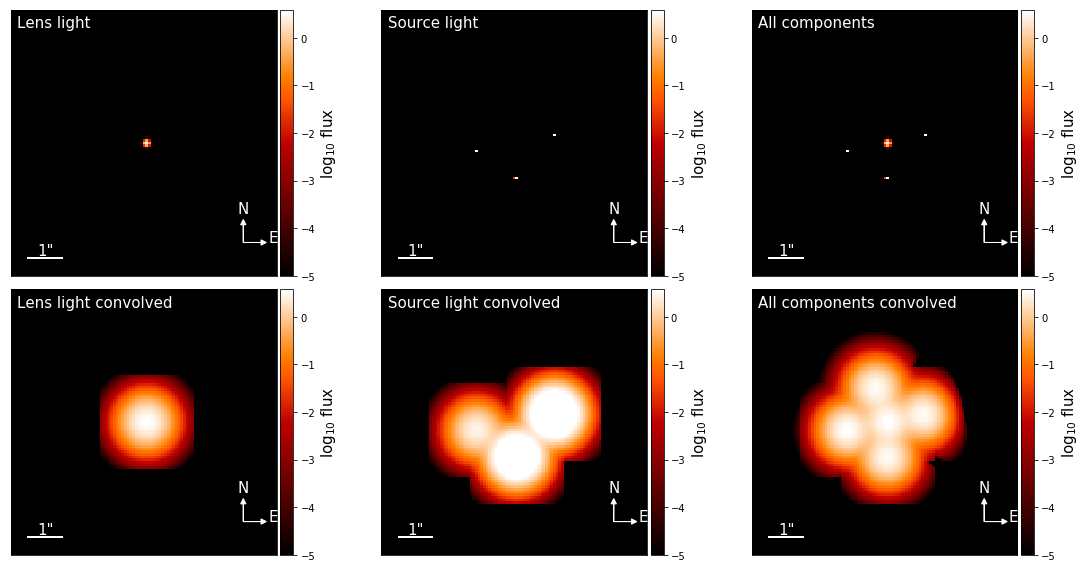

{'kwargs_lens': [{'theta_E': 1.0966387189697429, 'gamma': 1.724563292047474, 'e1': -0.02386338983366616, 'e2': 0.0009860835523401133, 'center_x': 0.01489834504481638, 'center_y': 0.01275191695217606}, {'gamma_ext': 0.027537229537558734, 'psi_ext': -2.567169123443916, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 70589123.62623978, 'R_sersic': 0.002187501894615774, 'n_sersic': 0.5986317887212956, 'e1': 0.40099106020491676, 'e2': -0.20583830446020457, 'center_x': 0.02980583511342855, 'center_y': 0.013324561915343328}], 'kwargs_lens_light': [{'amp': 19715.552146033224, 'R_sersic': 0.019539295219056098, 'n_sersic': 0.8729796301446499, 'center_x': 0.07715968138795863, 'center_y': -0.002094238231393978}], 'kwargs_ps': [{'ra_image': array([ 0.08241135, -1.12943438,  1.20777205, -0.27447638]), 'dec_image': array([-1.03582637, -0.23999426,  0.24293836,  1.01266842]), 'point_amp': array([-2235.46292882,   105.13639612, -3209.07374103,   385.48631051])}], 'kwargs_special': {}, 'kwargs_extinc

In [7]:
##### VAMOS A GRAFICAR LO QUE NOS DA 

from lenstronomy.Plots.output_plots import ModelPlot
import lenstronomy.Plots.output_plots as out_plot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

param_class = fitting_seq.param_class
print(param_class.num_param())
#print(chain_list)

for i in range(len(chain_list)):
    out_plot.plot_chain_list(chain_list, i)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
#f.tight_layout()
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
#plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)

number of non-linear parameters in the MCMC process:  19
parameters in order:  ['gamma_lens0', 'gamma_ext_lens1', 'psi_ext_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image']
number of evaluations in the MCMC process:  760


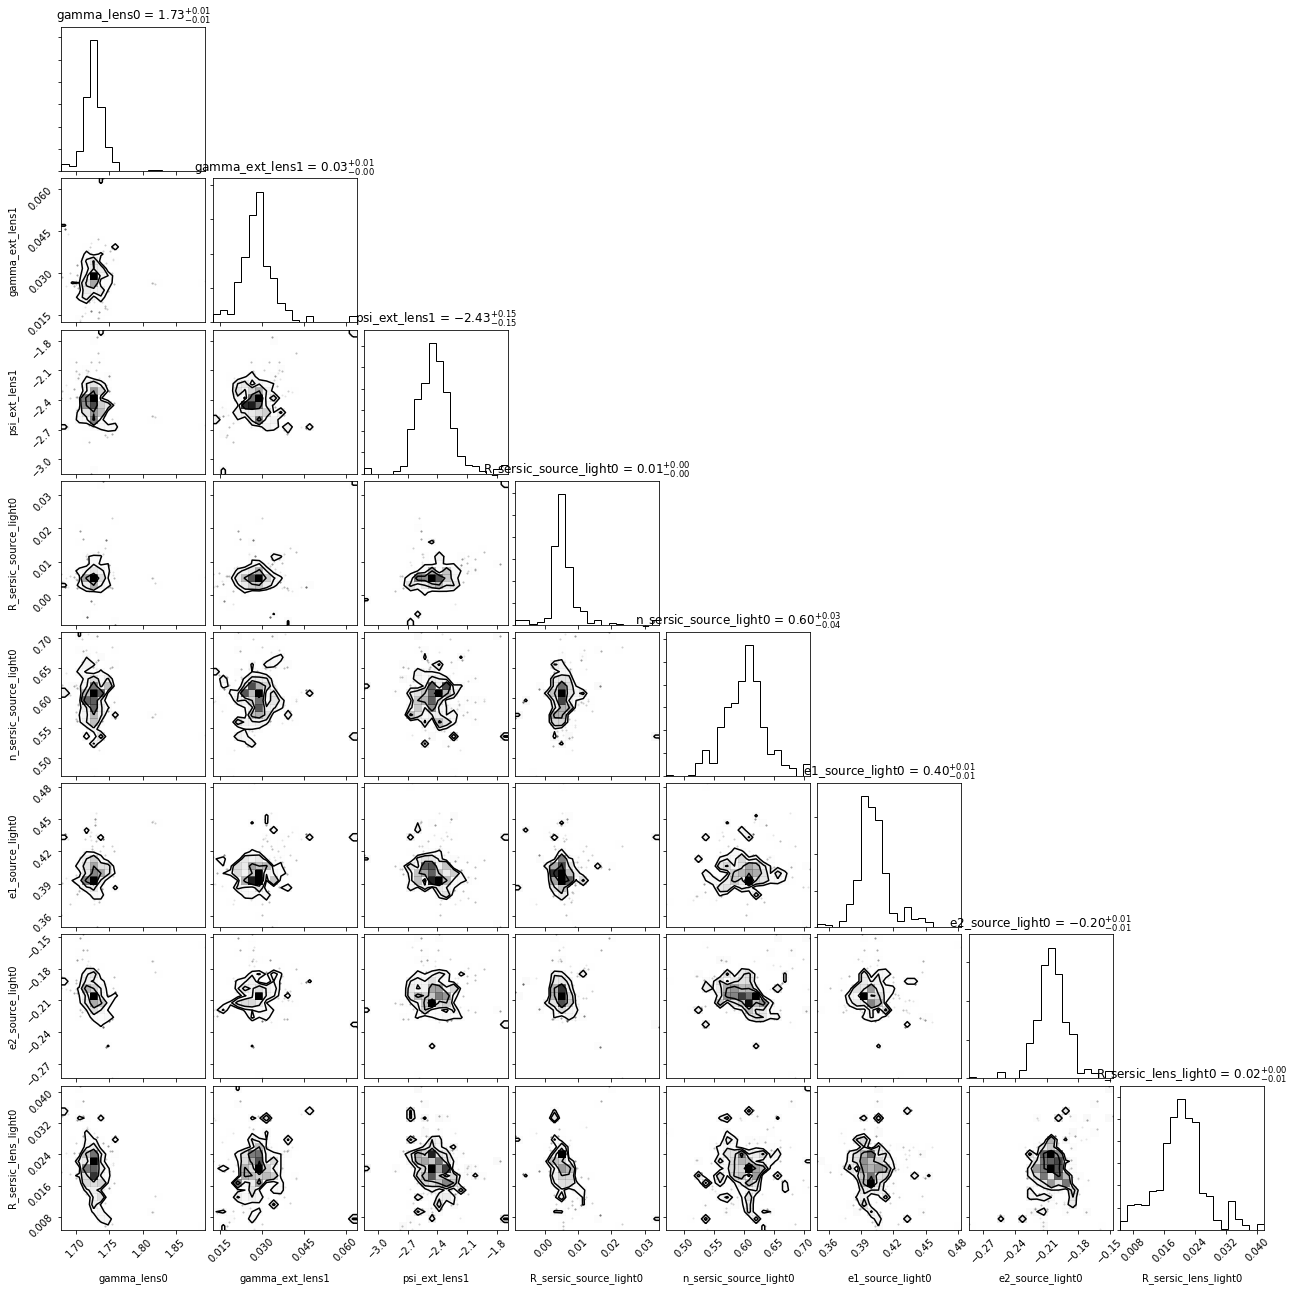

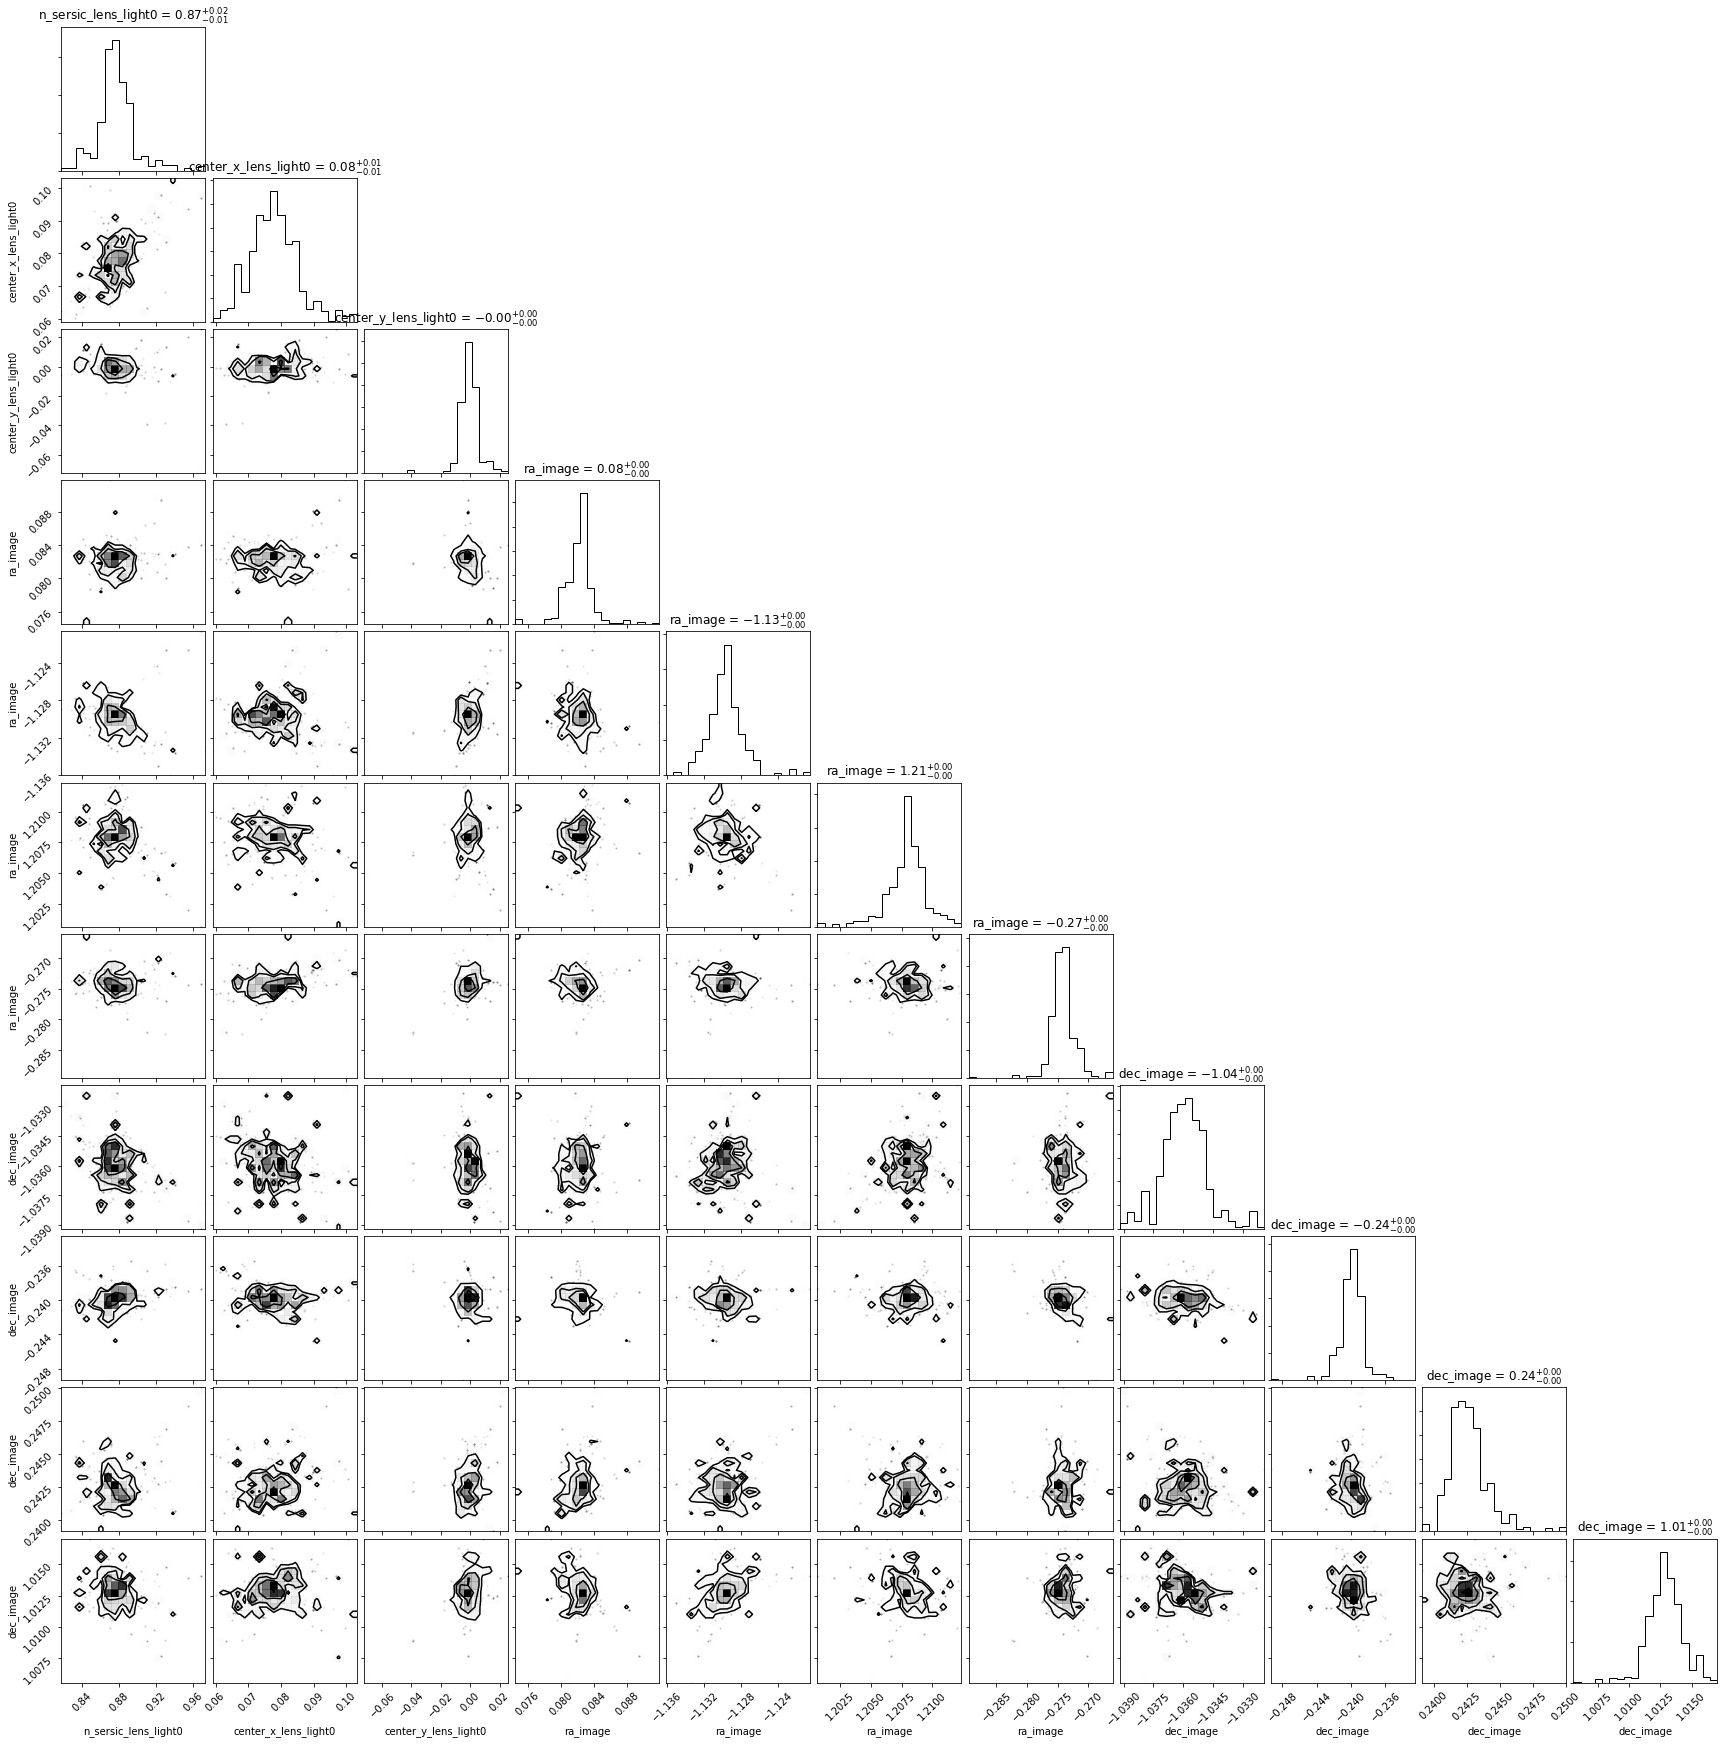

In [8]:
# INTRODUCIMOS LAS GAUSSIANAS

sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]
    
print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
import corner

n, num_param = np.shape(samples_mcmc)
plot = corner.corner(samples_mcmc[:,:8], labels=param_mcmc[:8], show_titles=True)
plot = corner.corner(samples_mcmc[:,8:], labels=param_mcmc[8:], show_titles=True)